<img align="right" src="https://nilearn.github.io/dev-days-2020/assets/images/nilearn-logo.png " alt="image" width="250"/>


# <p align="center"> MultiRat Sensory-Evoked analysis code </p>

*<p align="center"> Marie E Galteau, 2023  </p>*

***

## First Level Analysis - **Default** Hemodynamic Response Function

The present jupyter notebook contains the code to reproduce the first level analysis with nilearn's default hemodynamic response functions (HRF): spm or glover without derivates. The function has to be selected before running the analysis.

Follow the code step-wise. 


In [9]:
# ---  Imports --- 
import os
import glob
import nilearn
import numpy as np 
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from numpy import savetxt
from nilearn import image
from nilearn import masking
from nilearn import plotting, image
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import compute_regressor
from nilearn.glm.first_level import make_first_level_design_matrix
from IPython.display import Markdown, display

**Select the hemodynamic response function!** 

In [10]:
# --- Select HRF model ---

""" Define hrf model used for the first analysis
    Options : 
    ---------
    glover
    spm
"""

hrf_function = 'glover'
#hrf_function = 'spm'
print('The chosen HRF model is:', hrf_function)

The chosen HRF model is: glover


**Next step: define input and output directories.**

In [11]:
# --- Init variables --- 
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
            
# --- Data path ---
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
mask = '/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii'

# --- Output directories ---
output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/'
subdirectories = ['glover', 'spm']

base_dir = os.path.join(output_dir, 'glover') if hrf_function == 'glover' else os.path.join(output_dir, 'spm')
matrix_dir = os.path.join(base_dir, 'matrix/')
image_dir = os.path.join(base_dir, 'image/')
model_dir = os.path.join(base_dir, 'model/')
beta_dir = os.path.join(base_dir, 'beta_estimates/')
residuals_dir = os.path.join(base_dir, 'residuals/')
effect_var_dir = os.path.join(base_dir, 'effect_var/')
predic_timeseries_dir = os.path.join(base_dir, 'predicted_timeseries/')
z_score_dir = os.path.join(base_dir, 'z_score/')

for subdir in subdirectories:
    sub_dir = os.path.join(output_dir, subdir)
    sub_dir_structure = ['matrix', 'image', 'model', 'beta_estimates', 'residuals', 'effect_var', 'predicted_timeseries', 'z_score']
    
    for sub_subdir in sub_dir_structure:
        dir_path = os.path.join(sub_dir, sub_subdir)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
                    
            
# --- Load metadata ---    
df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

### Let's analyse!

1. Import the metadata file, whith the subject number, TR, timings, and other parameters are required for the analysis.
2. Define variables.
3. Compute the even regressors, basically the stimulation protocol.
4. Compute the motion regressors, output by RABIES preprocess pipeline in the cofounders.
5. Compute the design matrix and the first level model
6. Compute the contrast and plot the statistical maps
7. Save ouputs in specific directories

The chosen HRF model is: glover
index: 1
subj: 200101
TR: 2.0
n stim: 3
stim duration: 20
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


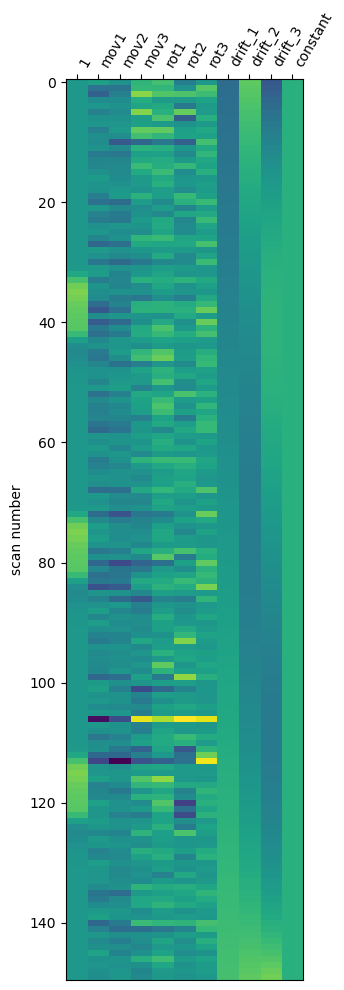

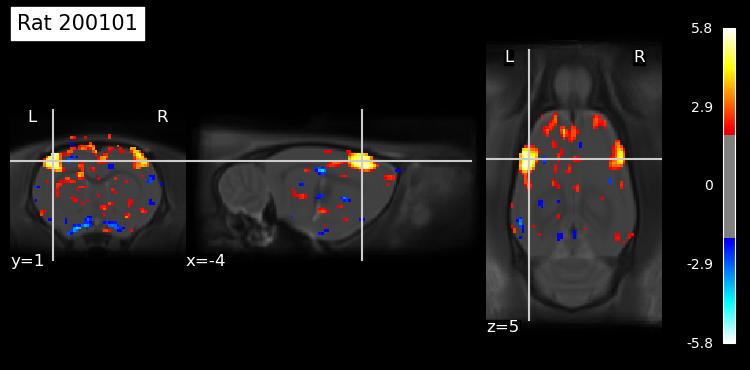

In [12]:
# ---------- FIRST LEVEL ANALYSIS ------------
# --------------- Default HRF ----------------

print('The chosen HRF model is:', hrf_function)

for index in range(1, 2):
    
    # --- Define variables --- 
    
    subj_num=str(df.iloc[index]['rat.sub'])[:-2]
    print('index:', index)
    print('subj:', subj_num)
    
    subject_path = glob.glob(analysis_folder + "/sub-0{}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, subj_num, subj_num))[0]
    func_img = nib.load(subject_path) 
    
    tr = (df.iloc[index]['func.TR']) 
    n_scans = func_img.shape[3]    
    frame_times = np.arange(n_scans) * tr                              

  # --- Events regressors ---     
    
    n_tr = np.count_nonzero((np.matrix(df.iloc[index]['func.sensory.onset'])))              #count number of stimulation, number of onset
    duration_1_stim = int(df.iloc[index]['func.sensory.duration'].split(',')[0].strip())
       
    onset_metadata = np.matrix(df.iloc[index]['func.sensory.onset']).A[0]                    # Get onsets from metadata file
    onsets = onset_metadata 
      
    durations = np.matrix(df.iloc[index]['func.sensory.duration']).A[0]
    trial_type = np.ones_like(onsets)
    events = pd.DataFrame({'trial_type': trial_type,'onset': onsets,'duration': durations})
    
    print('TR:', tr)
    print('n stim:', n_tr)
    print('stim duration:', duration_1_stim)
    
    # --- Motion regressors ---

    cofounders_file = 'sub-0{}_ses-1_run-1_bold_RAS_combined_confounds.csv'.format(subj_num)
    cofounders_path = glob.glob(analysis_folder +"/sub-0{}_ses-1/confounds_datasink/confounds_csv/*/*/*.csv".format(subj_num, subj_num, subj_num, subj_num))[0]

    cofounders = pd.read_csv(cofounders_path, sep=',')

    motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
    motion = np.array(cofounders[motion_names])
    
    
    # --- Design matrix and first-level model --- 
   
    design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                   events=events, 
                                                   add_regs=motion, 
                                                   add_reg_names=motion_names, 
                                                   drift_model="polynomial", 
                                                   drift_order=3, 
                                                   hrf_model=hrf_function,
                                                   high_pass=0.01)
    plot_design_matrix(design_matrix) 
    
    fmri_glm = FirstLevelModel(t_r=tr,
                               drift_model='polynomial',
                               signal_scaling=False,
                               smoothing_fwhm=0.45,
                               minimize_memory=False)
    
    fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)

    residuals = fmri_glm.residuals[0]
    predicted_timeseries = fmri_glm.predicted[0]
        
    # -- Coompute contrasts ---
    
    n_columns = design_matrix.shape[1]
    contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))
    print('Contrasts: ', contrast_val)

    statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')
        
    plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                       bg_img = template_path, 
                                       threshold = 1.9, 
                                       title = 'Rat {}'.format(subj_num))
        
    
    #-- Save outputs --  
    savetxt(matrix_dir+'matrix_sub-0{}_ses-1.csv'.format(subj_num), design_matrix, delimiter=',')
    nib.save(residuals, residuals_dir+'residuals_sub-0{}_ses-1.nii.gz'.format(subj_num))         #save this to nifti
    nib.save(predicted_timeseries, predic_timeseries_dir+'predicted_timeseries_sub-0{}_ses-1.nii.gz'.format(subj_num))  
    nib.save(statistical_map['z_score'], z_score_dir+'z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))           #save z map
    nib.save(statistical_map['effect_size'], beta_dir+'beta_sub-0{}_ses-1.nii.gz'.format(subj_num))             #save the betaestimates
    nib.save(statistical_map['effect_variance'], effect_var_dir+'effect_var_sub-0{}_ses-1.nii.gz'.format(subj_num))  #save the betaestimates
    plt.savefig(image_dir+'stat_map_sub-0{}_ses-1.png'.format(subj_num))


In [13]:
print('TR:', tr)
print('stim duration:', duration_1_stim)
    
print('n_scans', n_scans)
print('onsets', onsets)
print('frame_times', frame_times) 
print('events', events)

TR: 2.0
stim duration: 20
n_scans 150
onsets [ 60 140 220]
frame_times [  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198. 200. 202. 204. 206. 208. 210. 212. 214. 216. 218. 220. 222.
 224. 226. 228. 230. 232. 234. 236. 238. 240. 242. 244. 246. 248. 250.
 252. 254. 256. 258. 260. 262. 264. 266. 268. 270. 272. 274. 276. 278.
 280. 282. 284. 286. 288. 290. 292. 294. 296. 298.]
events    trial_type  onset  duration
0           1     60        20
1           1    140        20
2           1    220        20


**Save the modeled BOLD response**

First, extract the model from the first column of the design matrix. Plot it to check if it makes sense. 

We saved the model once per dataset, as stimulation protocols are similar across scans within each datasets.

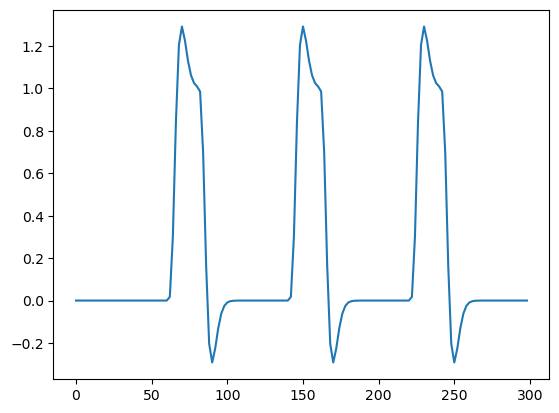

In [17]:
# --- SAVE MODEL ---
model = design_matrix.iloc[:, 0]
plt.plot(model)

savetxt(model_dir+'model_sub-0{}_ses-1.csv'.format(subj_num), model, delimiter=',')

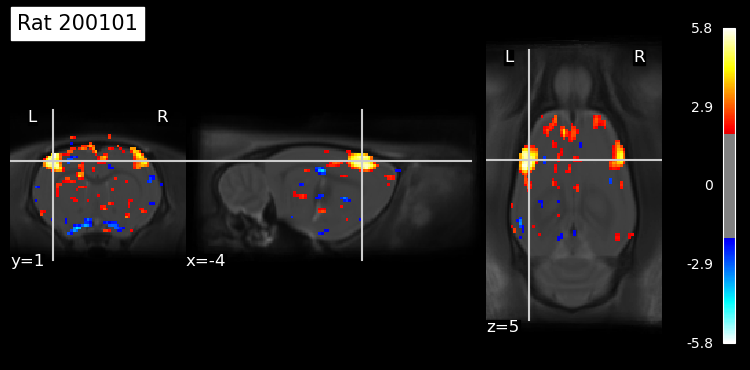

In [18]:
# --- Plot statistical map ---

colorbar = plot_stat._cbar                      # get the statistical scale from the plot
vmin, vmax = colorbar.mappable.get_clim()
set_tresh = vmax / 3                            # Set the threshold to 1/3 of the max value of the colorbar

plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                       bg_img = template_path, 
                                       threshold = set_tresh, 
                                       title = 'Rat {}'.format(subj_num))
    